トレーニング: 不動産価格予想

In [4]:
DIR_PATH = "/cpt_training"

In [5]:
cd {DIR_PATH}

[Errno 2] No such file or directory: '/cpt_training'
/Users/otoya/Documents/Develop/cpt_training


In [6]:
%pip install -U "setuptools<58" # setuptoolsのverが58以上だと、xfeatの依存パッケージml-metricsのinstallに失敗するため
%pip install -q optuna xfeat japanize-matplotlib
%pip install -q optuna


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# import
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer
# パラメータチューニングで必要なライブラリ
import optuna
from sklearn.metrics import mean_absolute_error

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
pd.set_option('display.max_columns', None)

In [9]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []
time_col = '取引時点_enc'
group_col = '都道府県名'

In [10]:
BASE_PATH = './'

In [11]:
paths = glob(BASE_PATH + 'input/train/*.csv')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'input/test.csv')

# train_df, test_df, val_dfをくっつける
master_df = pd.concat([train_df, test_df])
master_df.sort_values('取引時点', inplace=True)
master_df.reset_index(drop=True, inplace=True)

/var/folders/sq/rqkt9m8947d5f6h6fxf4t9q00000gn/T/ipykernel_45276/2232468179.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
/var/folders/sq/rqkt9m8947d5f6h6fxf4t9q00000gn/T/ipykernel_45276/2232468179.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)


In [12]:
master_df.columns

Index(['ID', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '間取り', '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造',
       '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等', '取引価格（総額）_log'],
      dtype='object')

In [13]:
set(test_df['取引時点'])

{'2020年第１四半期', '2020年第２四半期'}

In [14]:
sub_df = pd.read_csv(BASE_PATH + 'input/sample_submission.csv')

In [16]:
master_df.head(5)

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,13117957,中古マンション等,NaN,13104,東京都,新宿区,大久保,東新宿,NaN,１Ｋ,20,NaN,NaN,NaN,平成17年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,商業地域,80.0,600.0,2005年第３四半期,未改装,NaN,7.342423
1,13297424,中古マンション等,NaN,13114,東京都,中野区,弥生町,中野坂上,8,１Ｋ,15,NaN,NaN,NaN,昭和59年,ＲＣ,住宅,NaN,NaN,NaN,NaN,近隣商業地域,80.0,400.0,2005年第３四半期,未改装,NaN,6.633468
2,13208440,中古マンション等,NaN,13110,東京都,目黒区,碑文谷,都立大学,NaN,１Ｋ,20,NaN,NaN,NaN,平成17年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種住居地域,60.0,300.0,2005年第３四半期,NaN,NaN,7.301030
3,13356109,中古マンション等,NaN,13120,東京都,練馬区,大泉学園町,大泉学園,30分?60分,３ＬＤＫ,70,NaN,NaN,NaN,平成3年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種低層住居専用地域,50.0,100.0,2005年第３四半期,改装済,NaN,7.322219
4,23181954,中古マンション等,NaN,23104,愛知県,名古屋市西区,名西,浅間町,NaN,４ＬＤＫ,85,NaN,NaN,NaN,平成13年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,商業地域,80.0,400.0,2005年第３四半期,未改装,NaN,7.361728


In [ ]:
class Preprocessor:
    TARGET = TARGET
    group_col = group_col
    time_col = time_col

    def __init__(self, df):
        self.df = df.copy()
        self.agg_dfs = []
        self.rm_cols = []

    @staticmethod
    def normalize_moyori(moyori):
        if moyori == moyori:
            if moyori == '30分?60分':
                moyori = 45
            elif moyori == '1H?1H30':
                moyori = 75
            elif moyori == '1H30?2H':
                moyori = 105
            elif moyori == '2H?':
                moyori = 120
            moyori = int(float(moyori))
        return moyori

    @staticmethod
    def normalize_area(area):
        if area == area:
            area = int(re.sub('m\^2未満|㎡以上', '', str(area)))

    @staticmethod
    def convert_wareki_to_seireki(wareki):
        if wareki == wareki:
            if wareki == '戦前':
                wareki = '昭和20年'
            value = wareki[2:-1]
            if value == '元':
                value = 1
            else:
                value = int(value)
            if '昭和' in wareki:
                seireki = 1925+value
            elif '平成' in wareki:
                seireki = 1988+value
            elif '令和' in wareki:
                seireki = 2018+value
        else:
            seireki = wareki
        return seireki

    @staticmethod
    def allocate(data):
        if pd.isna(data) or data == "":
            return 0
        else:
            if 'LDK' in data:
                return 1
            elif 'DK' in data:
                return 2
            elif 'K' in data:
                return 3
            elif 'フリースペース' in data:
                return 4
            else:
                return 5

    @staticmethod
    def extract_room_count(s):
        if pd.isna(s) or s == '':
            return 0
        numbers = re.findall(r'\d+', s)
        return int(numbers[0]) if numbers else 0

    def name_to_number(self):
        """取引時点を数字に変更する関数"""
        enc_dic = {}
        for i, e in enumerate(sorted(list(set(self.df['取引時点'].values)))):
            enc_dic[e] = i
        self.df['取引時点_enc'] = self.df['取引時点'].map(enc_dic)
        return self.df

    def calc_mean_target(self):
        """各取引時点,都道府県での各都道府県のTARGETの平均値"""
        @staticmethod
        def calc_te(row):
            if row[self.time_col] in te_dic and row[self.group_col] in te_dic[row[self.time_col]]:
                try:
                    value = te_dic[row[self.time_col]-2][row[self.group_col]]
                except IndexError as e:
                    value = 0
                return value
            else:
                return 0
        te_dic = {}
        for i in set(self.df[time_col].values):
            tmp_df = self.df[self.df[time_col] < i]
            te_dic[i] = tmp_df.groupby(self.group_col)[TARGET].agg('mean').to_dict()
        # 最後にdfにapplyする
        self.df[self.group_col + '_te'] = self.df.apply(self.calc_te, axis=1)
        return self.df

    def get_agg_df(self):
        """group_valuesそれぞれのagg_methosを計算してくれるやつ"""
        agg_df, agg_cols = aggregation(self.df,
                            group_key=self.group_col,
                            group_values=['最寄駅：距離（分）', '容積率（％）'],
                            agg_methods=['count', 'mean', 'min', 'max'],
                            )
        return agg_df[agg_cols]

    def separate_data(self, target=''):
        """データを切り取って渡してくれる"""
        self.df.sort_values('取引時点', inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        val_min_idx = min(self.df[self.df['取引時点'].str.contains('2021年第4四半期|2022年第1四半期', regex=True)].index)
        test_min_idx = min(self.df[self.df['取引時点'].str.contains('2022年第2四半期|2022年第3四半期', regex=True)].index)
        feat_cols = [col for col in self.df.columns if col not in rm_cols+[ID, TARGET]]
        self.df.dropna(how='any', axis=0)
        if target == 'train':
            return self.df.iloc[:val_min_idx, :]
        elif target == 'val':
            return self.df.iloc[val_min_idx:test_min_idx, :]
        elif target == 'test':
            return self.df.iloc[test_min_idx:, :]

    def fit(self):
        self.df['取引時点_何年前'] = self.df['取引時点'].apply(lambda x: 2020-int(x[:4]))
        self.name_to_number()
        self.df.drop(columns=['取引時点'], axis=1, inplace=True)
        self.df['部屋数'] = self.df['間取り'].apply(self.extract_room_count)
        self.df['部屋タイプ'] = self.df['間取り'].apply(lambda x: self.allocate(x))
        self.df['建築年'] = self.df['建築年'].apply(lambda x: self.convert_wareki_to_seireki(x))
        self.df['面積（㎡）'] = self.df['面積（㎡）'].apply(lambda x: self.normalize_area(x))
        self.df['最寄駅：距離（分）'] = self.df['最寄駅：距離（分）'].apply(lambda x: self.normalize_moyori(x))

    def transform(self):
        num_df = SelectNumerical().fit_transform(self.df)
        encoder = Pipeline([
            SelectCategorical(),
            LabelEncoder(output_suffix=""),
            ])
        le_df = encoder.fit_transform(self.df)
        self.agg_dfs.append(self.get_agg_df())
        self.preprocessed_df = pd.concat([num_df,le_df]+self.agg_dfs, axis=1)
        return self.preprocessed_df

In [ ]:
# master_dfを処理していく
processor = Preprocessor(master_df)
processor.fit()
# processor.transform()
# processor.separate_data()


In [ ]:
# 都道府県別のTARGETの算出
df = pd.concat([train_df, val_df])
df = df.groupby('都道府県名').agg({TARGET: 'mean'})
df = df.rename(columns={TARGET: '都道府県別TARGET'})

train_x = pd.merge(train_x, df, on='都道府県名', how='right')
val_x = pd.merge(val_x, df, on='都道府県名', how='right')
test_x = pd.merge(test_x, df, on='都道府県名', how='right')

In [ ]:
test_x

,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引の事情等,取引時点_enc,部屋数,部屋タイプ,都道府県別TARGET
0,0,0,0,0,26.0,0,1989.0,0,-1,0,0,40.0,60.0,0,-1,1,3,5,7.386147
1,0,0,1,1,1.0,1,2016.0,0,-1,0,1,80.0,600.0,0,-1,0,2,5,7.386147
2,0,0,1,2,2.0,2,1989.0,1,-1,0,1,80.0,400.0,0,-1,1,1,5,7.386147
3,0,0,1,2,2.0,3,1991.0,1,-1,0,1,80.0,400.0,1,-1,1,1,5,7.386147
4,0,0,1,2,3.0,2,1981.0,0,-1,0,1,80.0,400.0,-1,-1,1,1,5,7.386147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19461,46,523,5511,-1,NaN,7,2019.0,0,0,0,1,80.0,400.0,0,-1,0,4,5,6.965009
19462,46,523,5511,-1,NaN,1,1998.0,0,-1,0,5,60.0,200.0,1,-1,0,2,5,6.965009
19463,46,523,5512,-1,NaN,7,2000.0,1,0,0,4,60.0,200.0,0,-1,0,4,5,6.965009
19464,46,524,5513,-1,NaN,0,2019.0,0,0,0,13,70.0,200.0,0,-1,0,3,5,6.965009


In [ ]:
# 19466行になってないとERRORになっている
test_df.shape

(19466, 27)

モデル構築

In [ ]:
train_set = lgb.Dataset(train_x, label=train_y)
val_set = lgb.Dataset(val_x, label=val_y)

In [ ]:
def objective(trial):
  params = {
      "objective": "regression",
      "metric": "mae",
      "boosting_type": "gbdt",
      "verbosity": -1,
      "boost_from_average": "false",
      "random_seed": 42,
      "feature_pre_filter": False,
      "max_depth": trial.suggest_int('max_depth', 4, 8),
      "num_leaves": trial.suggest_int("num_leaves", 2, 100),
      "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
      "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
      "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
      "min_child_samples": trial.suggest_int("min_child_samples", 1, 25),
      "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 4)
      }

  model = lgb.train(params, train_set, valid_sets=[val_set])

  pred_y = model.predict(val_x, num_iteration=model.best_iteration)
  mae = mean_absolute_error(val_y, pred_y)

  return mae

In [ ]:
val_df

,ID,最寄駅：距離（分）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,部屋数,部屋タイプ,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
612443,40028836,23.0,2013.0,60.0,150.0,7.447158,0,3,5,0,0,0,0,0,0,-1,0,0,0,-1,76,75,10.184211,248.133333,0.0,80.0,45.0,400.0
612444,40015179,5.0,2003.0,80.0,500.0,6.929419,0,1,5,0,1,1,1,1,0,-1,0,1,-1,-1,233,229,8.961373,373.799127,1.0,200.0,45.0,700.0
612445,1010624,4.0,1991.0,80.0,300.0,6.602060,0,1,5,1,2,2,2,1,0,-1,0,2,0,-1,98,97,7.918367,269.072165,0.0,200.0,45.0,600.0
612446,40021376,4.0,1997.0,80.0,400.0,7.113943,0,3,5,0,3,3,3,0,0,-1,0,1,-1,-1,101,96,18.950495,230.729167,0.0,100.0,75.0,500.0
612447,33000366,21.0,1978.0,80.0,400.0,6.230449,0,0,5,2,4,4,4,2,1,-1,1,1,0,-1,65,63,18.276923,344.444444,2.0,100.0,45.0,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637346,26014848,4.0,1999.0,80.0,200.0,7.579784,1,3,5,7,227,6306,2727,0,0,-1,0,2,0,-1,52,50,8.211538,228.000000,0.0,200.0,45.0,400.0
637347,13038610,10.0,2009.0,80.0,300.0,7.342423,1,1,5,6,35,444,1534,1,0,-1,0,2,0,-1,366,359,5.554645,399.303621,0.0,150.0,15.0,800.0
637348,13152450,6.0,2009.0,80.0,600.0,7.623249,1,2,5,6,59,288,367,3,0,-1,0,1,0,-1,376,373,7.372340,301.823056,0.0,80.0,16.0,600.0
637349,13061473,11.0,2012.0,80.0,300.0,7.255273,1,1,5,6,12,3322,370,1,0,0,0,2,-1,-1,565,562,6.874336,295.729537,1.0,100.0,25.0,700.0


In [ ]:
train_df

,ID,最寄駅：距離（分）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,部屋数,部屋タイプ,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,13212242,8.0,1987.0,60.0,200.0,6.838849,0,1,5,0,0,0,0,0,0,0,-1,0,0,-1,11150,11540,7.135516,295.362218,0.0,80.0,45.0,800.0
1,11067436,NaN,2002.0,NaN,NaN,7.397940,0,3,5,1,1,1,1,1,-1,0,-1,-1,0,-1,1964,2013,11.553971,282.861401,1.0,150.0,120.0,900.0
2,13343000,9.0,1990.0,60.0,200.0,6.724276,0,1,5,0,2,2,2,0,1,0,-1,0,1,-1,7648,8031,7.477249,298.800897,0.0,80.0,120.0,800.0
3,14245156,NaN,1971.0,NaN,NaN,6.908485,0,2,5,2,3,3,3,2,-1,0,-1,-1,0,-1,871,888,20.192882,164.493243,0.0,80.0,105.0,500.0
4,27221871,15.0,2001.0,NaN,NaN,7.301030,0,3,5,3,4,4,4,1,1,0,-1,-1,1,-1,3834,3915,7.170318,402.388250,0.0,150.0,120.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612438,21004967,14.0,1993.0,80.0,400.0,7.477121,55,3,5,6,99,3211,385,1,0,0,0,2,0,-1,785,793,31.164331,312.358134,1.0,100.0,120.0,600.0
612439,27031324,0.0,2008.0,80.0,600.0,7.806180,55,2,5,3,46,10044,983,2,1,0,0,2,0,-1,3902,4147,5.760636,486.009163,0.0,80.0,19.0,1000.0
612440,11085042,6.0,2016.0,60.0,200.0,7.556303,55,3,5,1,395,266,2021,1,1,0,0,0,0,-1,1482,1499,13.184211,238.225484,0.0,200.0,105.0,500.0
612441,13061649,5.0,1970.0,60.0,300.0,7.612784,55,2,5,0,0,706,509,2,0,0,0,6,1,-1,11150,11540,7.135516,295.362218,0.0,80.0,45.0,800.0


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-11-14 09:44:41,095] A new study created in memory with name: no-name-34a109e1-285d-4e1c-b9c7-1280f441afe6
[I 2023-11-14 09:44:49,154] Trial 0 finished with value: 1.4159793559263856 and parameters: {'max_depth': 6, 'num_leaves': 28, 'learning_rate': 0.01659176147282461, 'feature_fraction': 0.2557917879307843, 'bagging_fraction': 0.838951232522223, 'min_child_samples': 3, 'min_data_in_leaf': 2}. Best is trial 0 with value: 1.4159793559263856.
[I 2023-11-14 09:44:53,255] Trial 1 finished with value: 0.30462193910118307 and parameters: {'max_depth': 4, 'num_leaves': 95, 'learning_rate': 0.0464280399513051, 'feature_fraction': 0.7968778207070136, 'bagging_fraction': 0.10703396452245952, 'min_child_samples': 18, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.30462193910118307.
[I 2023-11-14 09:45:01,748] Trial 2 finished with value: 0.291223789145593 and parameters: {'max_depth': 5, 'num_leaves': 81, 'learning_rate': 0.07338336109617105, 'feature_fraction': 0.9691979864748659

In [ ]:
best_params = study.best_params
# 最適モデルで再度トレーニング
model = lgb.train(best_params, train_set, valid_sets=[val_set]) # early_stopping_roundsは使えなくなったそう。

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 612443, number of used features: 19
[LightGBM] [Info] Start training from score 7.214606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [ ]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

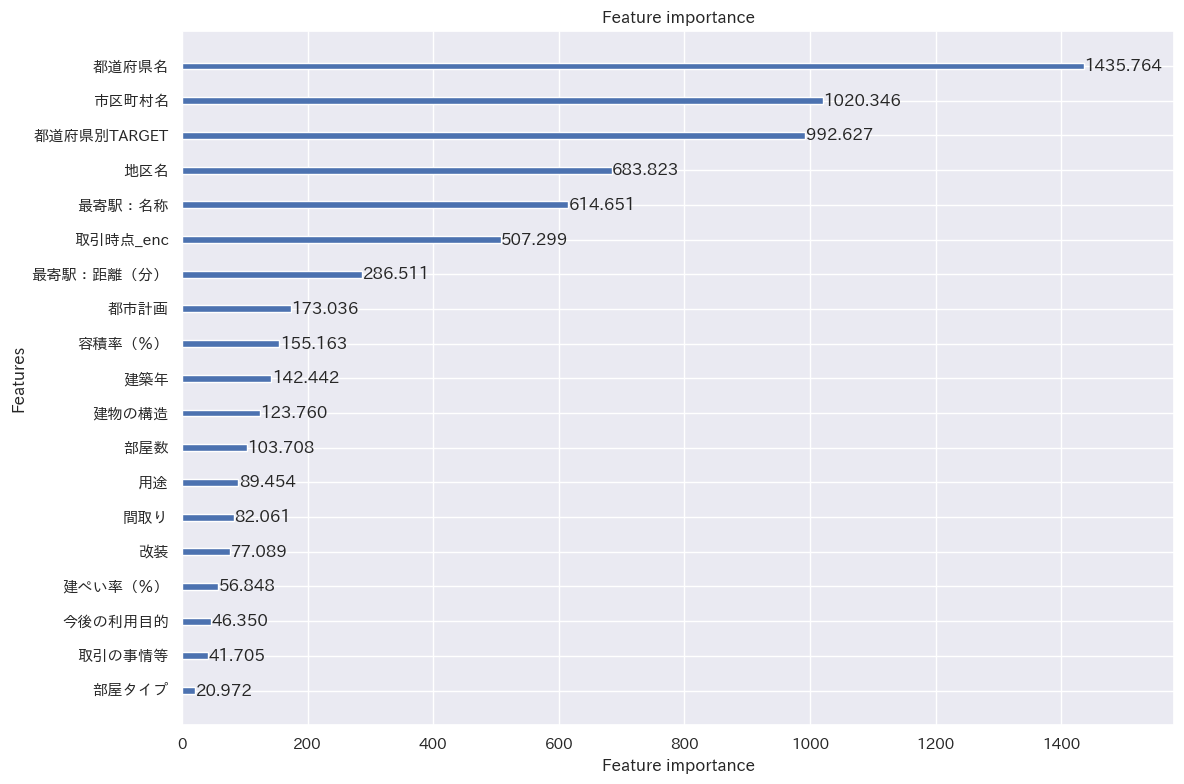

In [ ]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()

In [ ]:
test_df[TARGET] = test_pred

In [ ]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/test_submission.csv', index=False)